# Chapter 1 

## Exercise 2

Let's modify our simple data analysis pipeline so that it can handle another classifications task: classifying breast cancers from a [another famous dataset](http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29). This problem is bit trickier for a simple model such as decision tree, so let's try out [random forest classifier](https://en.wikipedia.org/wiki/Random_forest), which uses an ensemble of decision trees and let's compare the results. 

Problems are presented below our previous pipeline.

In [2]:
# Load libraries
library(tidyverse)
library(broom)
library(modelr)
library(rpart)
library(caret)
library(stringr)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘modelr’

The following object is masked from ‘package:broom’:

    bootstrap

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [3]:
# Define iris data loading function
load_iris <- function(iris_data_file) {
    iris_data <- read_csv(iris_data_file, col_names=c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species')) %>%
        mutate(Species=str_remove(Species, 'Iris-')) %>%
        mutate(Species=as.factor(Species)) %>%
        rename(Target=Species)
    return(iris_data)
}

# Define function for dataset row shuffling
shuffle_rows <- function(data) {
    sample_ix <- sample(nrow(data))
    shuffled_data <- data[sample_ix,]
    return(shuffled_data)
}

# Define function for dataset splitting
split_dataset <- function(data, train_fraction=0.8) {
    dataset_split <- data %>%
        resample_partition(c(train=train_fraction, test=1-train_fraction))
    print('Train split proportions:')
    dataset_split$train %>%
        as_tibble() %>%
        group_by(Target) %>%
        tally() %>%
        show()
    print('Test split proportions:')
    dataset_split$test %>%
        as_tibble() %>%
        group_by(Target) %>%
        tally() %>%
        show()
    return(dataset_split)
}

# Define function for decision tree classification
decision_tree_classifier <- function(train_data) {
    fitted_tree <- train_data %>%
        as_tibble() %>%
        rpart(Target ~ ., data=., method='class')
    print(fitted_tree)
    return(fitted_tree)
}

# Define function for model evaluation
prediction_evaluation <- function(test_data, model) {
    prediction_data <- test_data %>%
        as_tibble() %>%
        mutate(PredictedValue = predict(model, newdata=., type='class')) %>%
        mutate(Prediction=ifelse(Target == PredictedValue, str_to_title(as.character(Target)), 'Classification failure'))
    show(confusionMatrix(prediction_data$Target, prediction_data$PredictedValue))
    return(prediction_data)
}

# Define function for prediction plotting
plot_predictions <- function(fitted_data, x, y) {
    options(repr.plot.width=13, repr.plot.height=7)
    ggplot(data=fitted_data, aes_string(x=x, y=y, color='Prediction')) +
        geom_point()
}

Parsed with column specification:
cols(
  Sepal.Length = col_double(),
  Sepal.Width = col_double(),
  Petal.Length = col_double(),
  Petal.Width = col_double(),
  Species = col_character()
)


[1] "Train split proportions:"
# A tibble: 3 x 2
  Target         n
  <fct>      <int>
1 setosa        38
2 versicolor    40
3 virginica     41
[1] "Test split proportions:"
# A tibble: 3 x 2
  Target         n
  <fct>      <int>
1 setosa        12
2 versicolor    10
3 virginica      9
n= 119 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 119 78 virginica (0.31932773 0.33613445 0.34453782)  
  2) Petal.Length< 2.45 38  0 setosa (1.00000000 0.00000000 0.00000000) *
  3) Petal.Length>=2.45 81 40 virginica (0.00000000 0.49382716 0.50617284)  
    6) Petal.Width< 1.75 43  4 versicolor (0.00000000 0.90697674 0.09302326) *
    7) Petal.Width>=1.75 38  1 virginica (0.00000000 0.02631579 0.97368421) *
Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         10         0
  virginica       0          1         8

Overall Statistics
                           

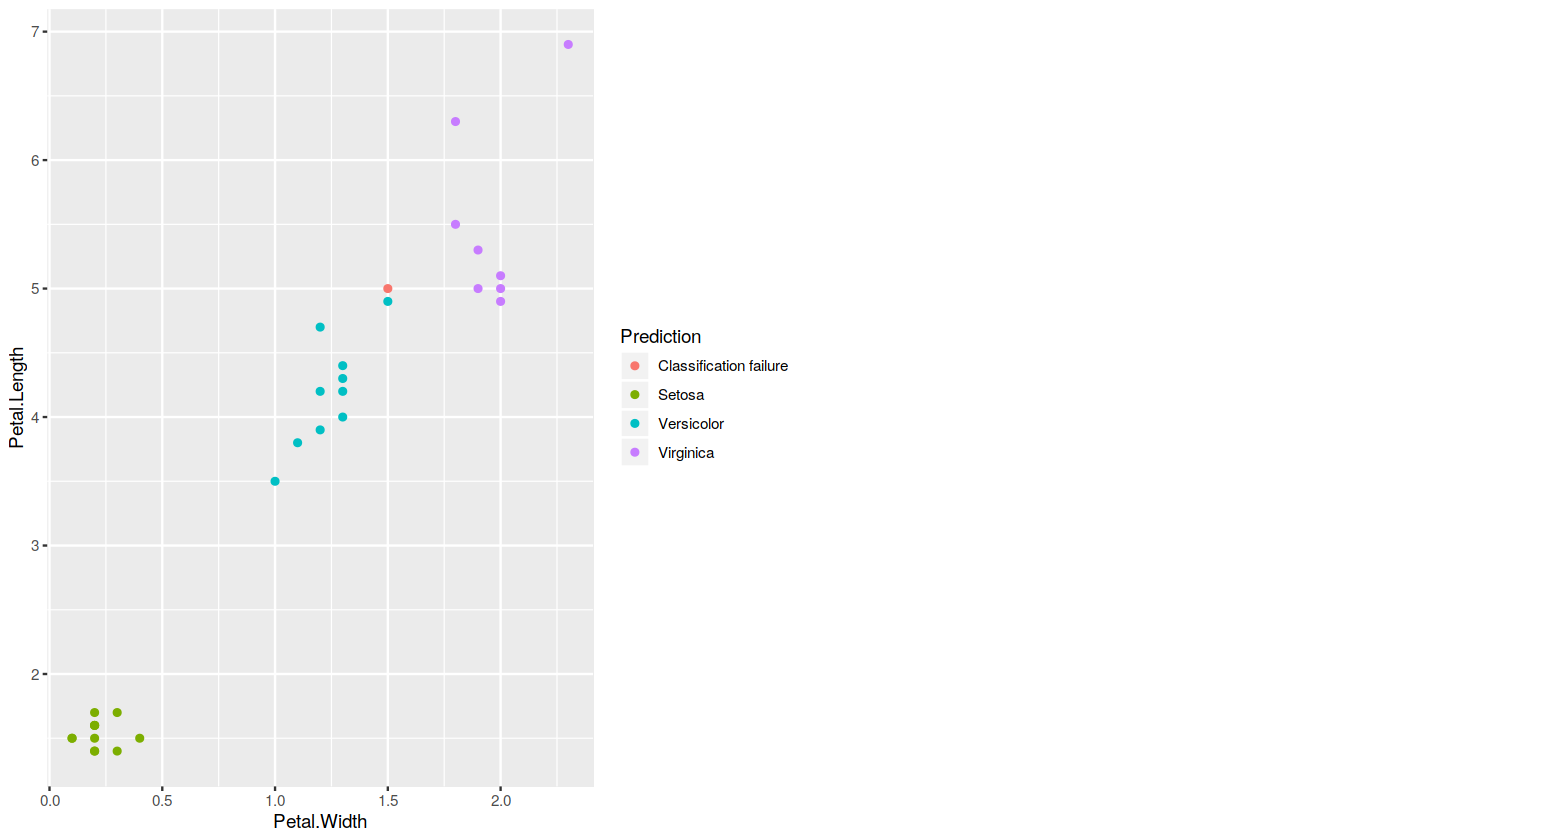

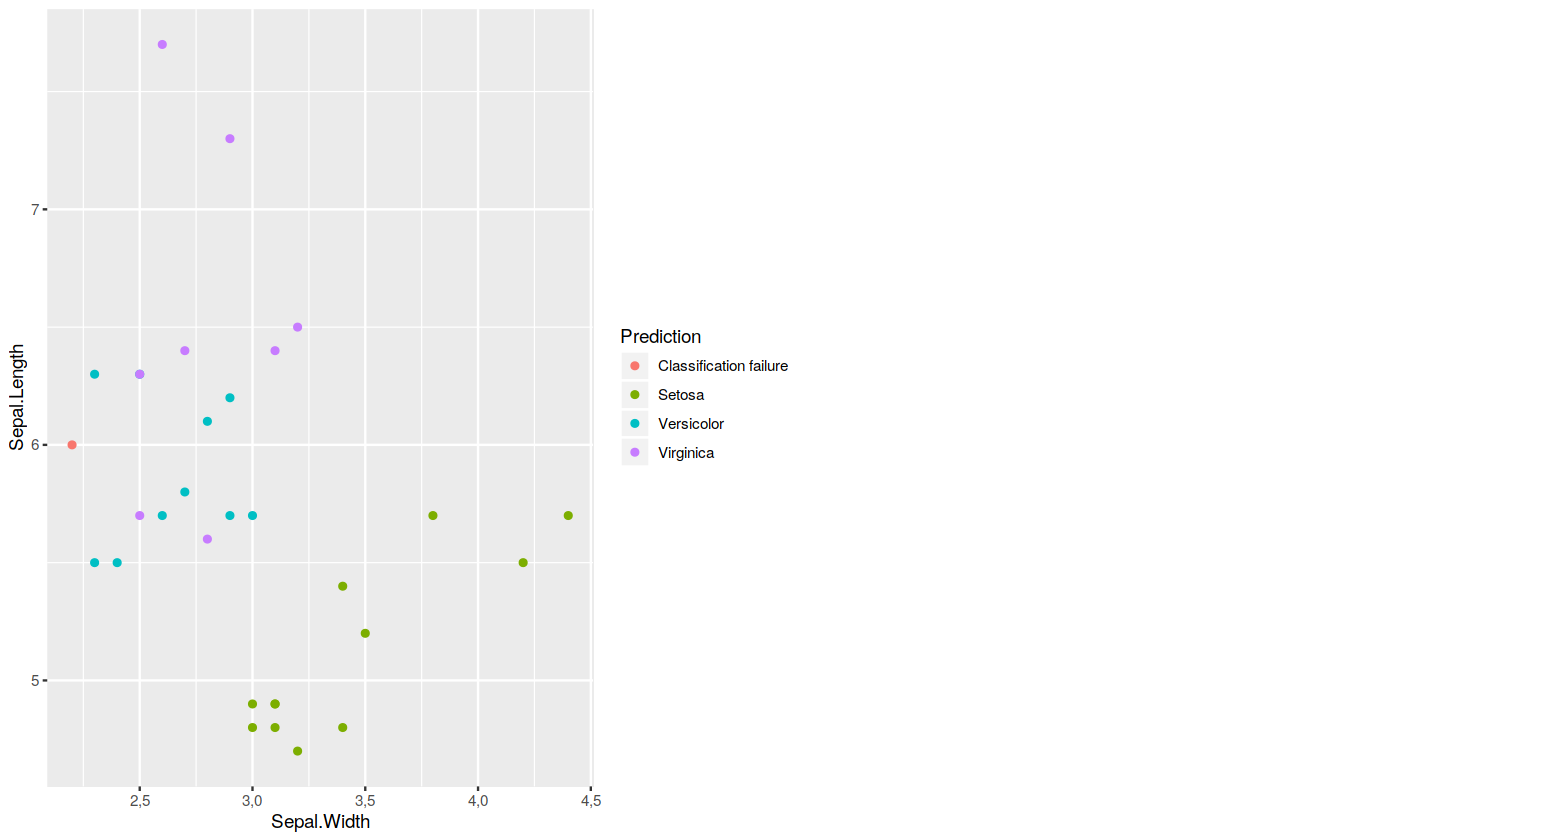

In [4]:
set.seed(42)
iris_data <- load_iris('../data/iris.data')
iris_data <- shuffle_rows(iris_data)
iris_split <- split_dataset(iris_data, train_fraction=0.8)
iris_fitted_tree <- decision_tree_classifier(iris_split$train)
iris_predicted <- prediction_evaluation(iris_split$test, iris_fitted_tree)
plot_predictions(iris_predicted, x='Petal.Width', y='Petal.Length')
plot_predictions(iris_predicted, x='Sepal.Width', y='Sepal.Length')

## Problem 1

The dataset contains 32 columns:
- index number
- diagnosis for the cancer (M = malignant, B = benign)
- 30 columns of data

Below is a call to [read_csv](https://readr.tidyverse.org/reference/read_delim.html)-function that gives all columns a name `Xn`.

Tasks are the following:

- Create a new function `load_wdbc` that takes as its argument the path to the `wdbc.data`-dataset.
- The function must return the data in the following format:
    - The column `X1`, which houses the patient index, must be dropped, as it is not an actual variable.
    - The column `X2`, which houses our target variable, must be formatted into categorical variable
    - The column `X2`, which houses our target variable, must be renamed as `Target`, as our following functions assume that column houses the target variable

Use the `load_iris`-function as an example for this task.

In [5]:
wdbc_data <- read_csv('../data/wdbc.data', col_names=FALSE)
head(wdbc_data)

Parsed with column specification:
cols(
  .default = col_double(),
  X2 = col_character()
)
See spec(...) for full column specifications.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
842302,M,"17,99","10,38","122,80","1001,0","0,11840","0,27760","0,3001","0,14710",...,"25,38","17,33","184,60","2019,0","0,1622","0,6656","0,7119","0,2654","0,4601","0,11890"
842517,M,"20,57","17,77","132,90","1326,0","0,08474","0,07864","0,0869","0,07017",...,"24,99","23,41","158,80","1956,0","0,1238","0,1866","0,2416","0,1860","0,2750","0,08902"
84300903,M,"19,69","21,25","130,00","1203,0","0,10960","0,15990","0,1974","0,12790",...,"23,57","25,53","152,50","1709,0","0,1444","0,4245","0,4504","0,2430","0,3613","0,08758"
84348301,M,"11,42","20,38","77,58","386,1","0,14250","0,28390","0,2414","0,10520",...,"14,91","26,50","98,87","567,7","0,2098","0,8663","0,6869","0,2575","0,6638","0,17300"
84358402,M,"20,29","14,34","135,10","1297,0","0,10030","0,13280","0,1980","0,10430",...,"22,54","16,67","152,20","1575,0","0,1374","0,2050","0,4000","0,1625","0,2364","0,07678"
843786,M,"12,45","15,70","82,57","477,1","0,12780","0,17000","0,1578","0,08089",...,"15,47","23,75","103,40","741,6","0,1791","0,5249","0,5355","0,1741","0,3985","0,12440"


In [6]:
load_wdbc <- function(wdbc_data_file) {
    wdbc_data <- read_csv(wdbc_data_file, col_names=FALSE) %>%
        select(-X1) %>%
        mutate(X2=as.factor(X2)) %>%
        rename(Target=X2)
    return(wdbc_data)
}
wdbc_data <- load_wdbc('../data/wdbc.data')
head(wdbc_data)

Parsed with column specification:
cols(
  .default = col_double(),
  X2 = col_character()
)
See spec(...) for full column specifications.


Target,X3,X4,X5,X6,X7,X8,X9,X10,X11,...,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
M,"17,99","10,38","122,80","1001,0","0,11840","0,27760","0,3001","0,14710","0,2419",...,"25,38","17,33","184,60","2019,0","0,1622","0,6656","0,7119","0,2654","0,4601","0,11890"
M,"20,57","17,77","132,90","1326,0","0,08474","0,07864","0,0869","0,07017","0,1812",...,"24,99","23,41","158,80","1956,0","0,1238","0,1866","0,2416","0,1860","0,2750","0,08902"
M,"19,69","21,25","130,00","1203,0","0,10960","0,15990","0,1974","0,12790","0,2069",...,"23,57","25,53","152,50","1709,0","0,1444","0,4245","0,4504","0,2430","0,3613","0,08758"
M,"11,42","20,38","77,58","386,1","0,14250","0,28390","0,2414","0,10520","0,2597",...,"14,91","26,50","98,87","567,7","0,2098","0,8663","0,6869","0,2575","0,6638","0,17300"
M,"20,29","14,34","135,10","1297,0","0,10030","0,13280","0,1980","0,10430","0,1809",...,"22,54","16,67","152,20","1575,0","0,1374","0,2050","0,4000","0,1625","0,2364","0,07678"
M,"12,45","15,70","82,57","477,1","0,12780","0,17000","0,1578","0,08089","0,2087",...,"15,47","23,75","103,40","741,6","0,1791","0,5249","0,5355","0,1741","0,3985","0,12440"


## Problem 2

Test out your dataset loading function with the following pipeline. What was the accuracy of the model?

The [documentation of the dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names) describes the dataset as follows:

```
Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

Several of the papers listed above contain detailed descriptions of
how these features are computed. 

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.
```

Can you explain why our plot looks so linear?

Parsed with column specification:
cols(
  .default = col_double(),
  X2 = col_character()
)
See spec(...) for full column specifications.


[1] "Train split proportions:"
# A tibble: 2 x 2
  Target     n
  <fct>  <int>
1 B        287
2 M        168
[1] "Test split proportions:"
# A tibble: 2 x 2
  Target     n
  <fct>  <int>
1 B         70
2 M         44
n= 455 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 455 168 B (0,63076923 0,36923077)  
   2) X23< 16,805 305  27 B (0,91147541 0,08852459)  
     4) X30< 0,1358 270   5 B (0,98148148 0,01851852) *
     5) X30>=0,1358 35  13 M (0,37142857 0,62857143)  
      10) X24< 25,67 15   3 B (0,80000000 0,20000000) *
      11) X24>=25,67 20   1 M (0,05000000 0,95000000) *
   3) X23>=16,805 150   9 M (0,06000000 0,94000000)  
     6) X4< 14,99 9   3 B (0,66666667 0,33333333) *
     7) X4>=14,99 141   3 M (0,02127660 0,97872340) *
Confusion Matrix and Statistics

          Reference
Prediction  B  M
         B 67  3
         M  2 42
                                          
               Accuracy : 0,9561          
                 95% CI : (0,9006,

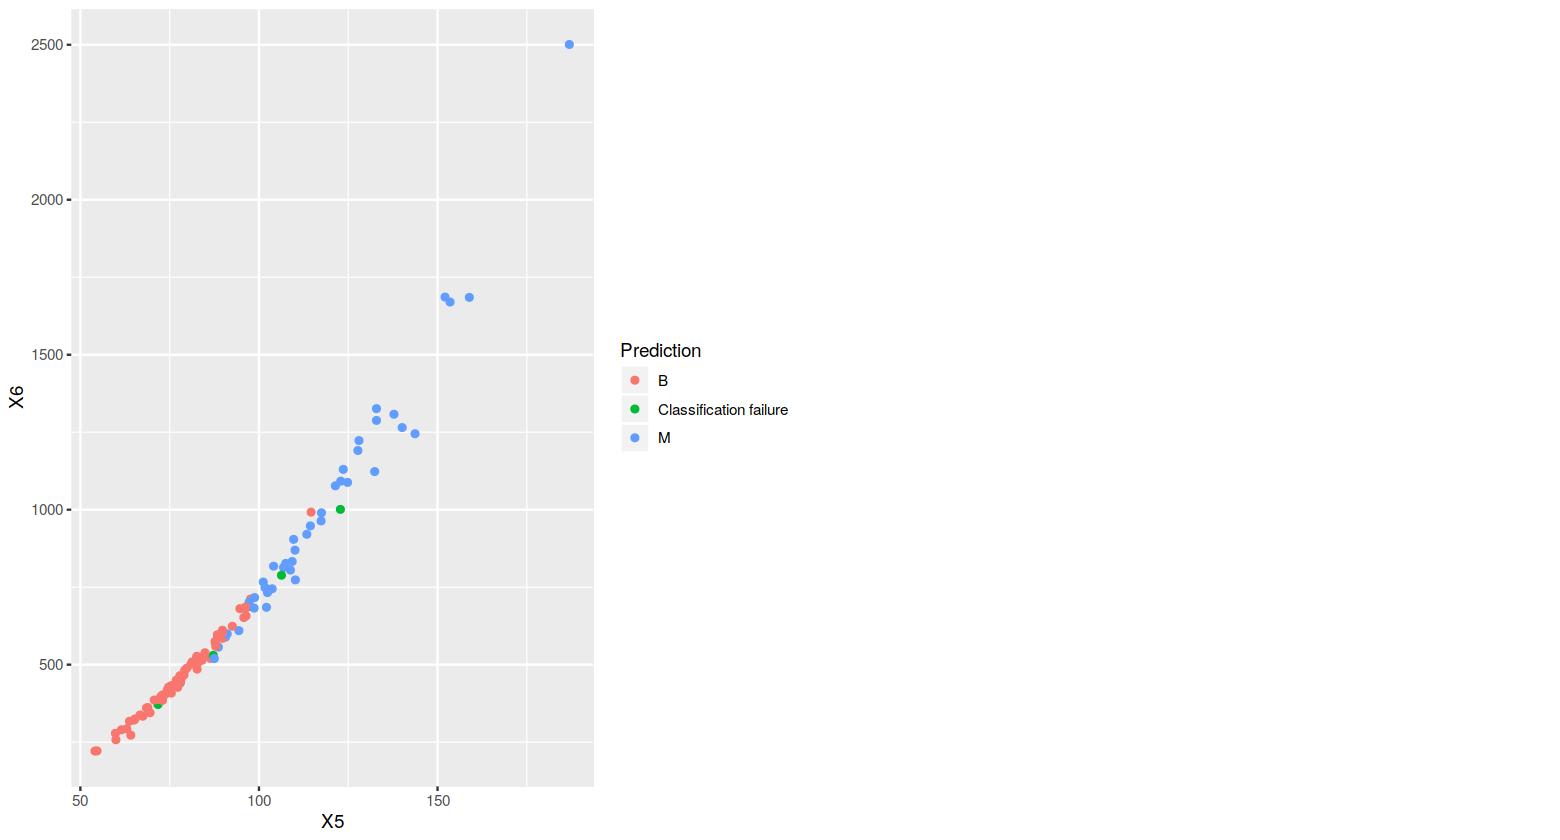

In [7]:
set.seed(42)
wdbc_data <- load_wdbc('../data/wdbc.data')
wdbc_data <- shuffle_rows(wdbc_data)
wdbc_split <- split_dataset(wdbc_data, train_fraction=0.8)
wdbc_fitted_tree <- decision_tree_classifier(wdbc_split$train)
wdbc_predicted <- prediction_evaluation(wdbc_split$test, wdbc_fitted_tree)
plot_predictions(wdbc_predicted, x='X5', y='X6')

# Problem 3

Let's try using a [randomForest](https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest) from the package [randomForest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf) for our task instead of a decision tree classifier.

Tasks are:

- Create a new function `random_forest_classifier` that:
    - takes a training dataset as its input
    - creates a `randomForest`
    - trains the random forest with the training dataset
    - returns the fitted forest

The `randomForest` requires a bit different arguments than `rpart`: Instead of `method='class'` use `type='classification'` to tell the function that the problem at hand is a classification problem.

Use the `decision_tree_classifier`-function as a template.

Do note that it is not as easy to print the rules that the random forest uses for its decision making: random forest uses multiple (by default 100) decision trees so one would need to print all of them. Thus you do not need to include the `print`-statement.

In [8]:
library(randomForest)
# Define function for random forest classification
random_forest_classifier <- function(train_data) {
    fitted_forest <- train_data %>%
        as_tibble() %>%
        randomForest(Target ~ ., data=., type='classification')
    return(fitted_forest)
}

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



Confusion Matrix and Statistics

          Reference
Prediction  B  M
         B 68  2
         M  0 44
                                          
               Accuracy : 0,9825          
                 95% CI : (0,9381, 0,9979)
    No Information Rate : 0,5965          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0,9633          
                                          
 Mcnemar's Test P-Value : 0,4795          
                                          
            Sensitivity : 1,0000          
            Specificity : 0,9565          
         Pos Pred Value : 0,9714          
         Neg Pred Value : 1,0000          
             Prevalence : 0,5965          
         Detection Rate : 0,5965          
   Detection Prevalence : 0,6140          
      Balanced Accuracy : 0,9783          
                                          
       'Positive' Class : B               
                                    

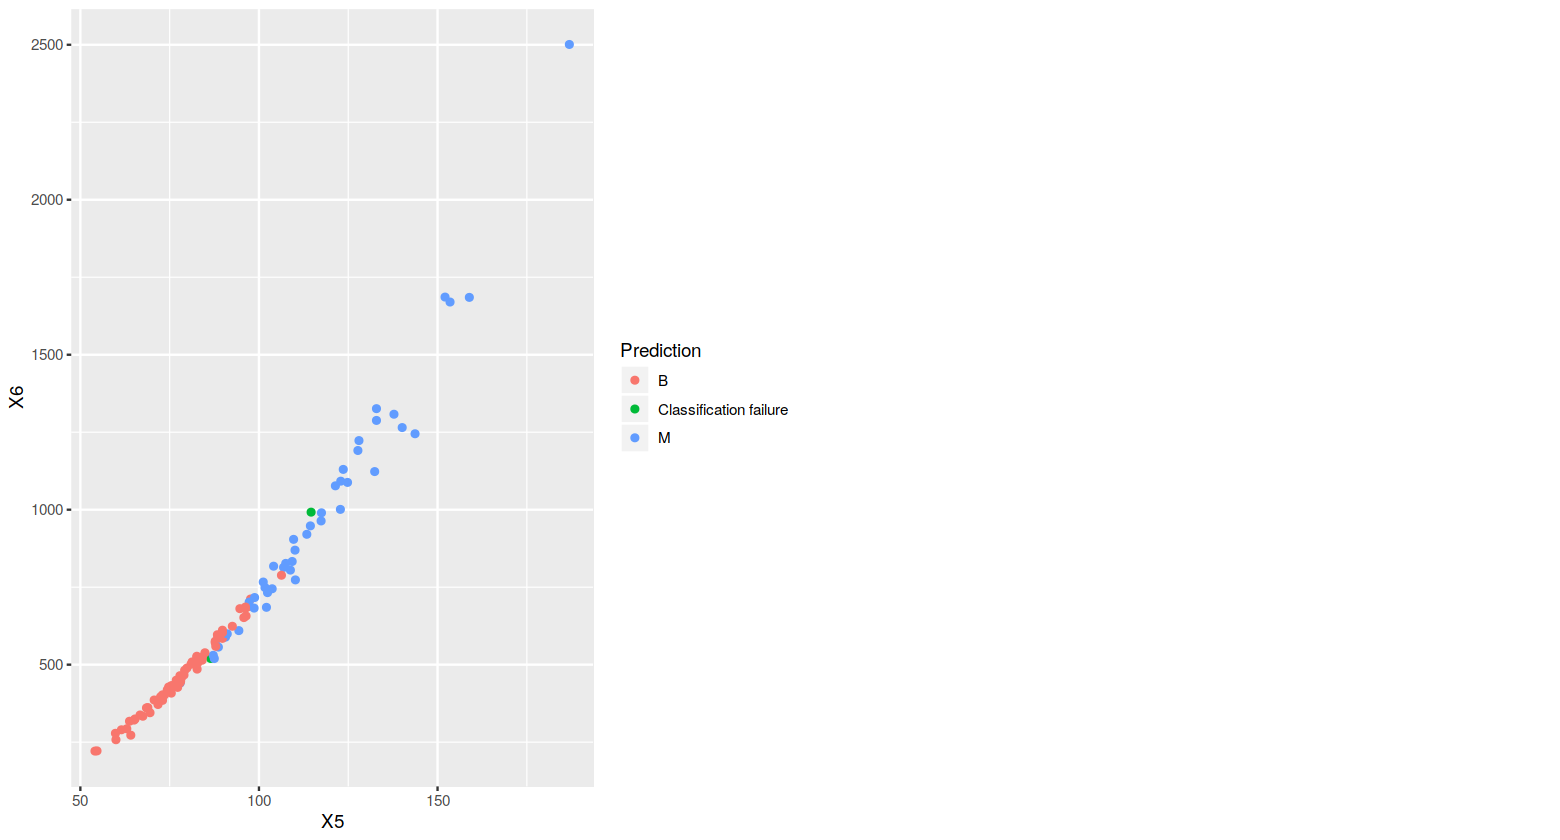

In [11]:
wdbc_fitted_forest <- random_forest_classifier(wdbc_split$train)
wdbc_predicted_forest <- prediction_evaluation(wdbc_split$test, wdbc_fitted_forest)
plot_predictions(wdbc_predicted_forest, x='X5', y='X6')

## Problem 4

Let's try to improve our old iris-pipeline with our newly created `random_forest_classifier`.

Tasks:
- Create a new iris pipeline that uses our `random_forest_classifier` without creating any new functions.
- Compare the accuracy. DId it improve? If it did/did not, can you think why that was the case?

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         10         0
  virginica       0          1         8

Overall Statistics
                                         
               Accuracy : 0,9677         
                 95% CI : (0,833, 0,9992)
    No Information Rate : 0,3871         
    P-Value [Acc > NIR] : 8,358e-12      
                                         
                  Kappa : 0,9512         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1,0000            0,9091           1,0000
Specificity                 1,0000            1,0000           0,9565
Pos Pred Value              1,0000            1,0000           0,8889
Neg Pred Value              1,0000            0,9524           1,0000
Prevalence

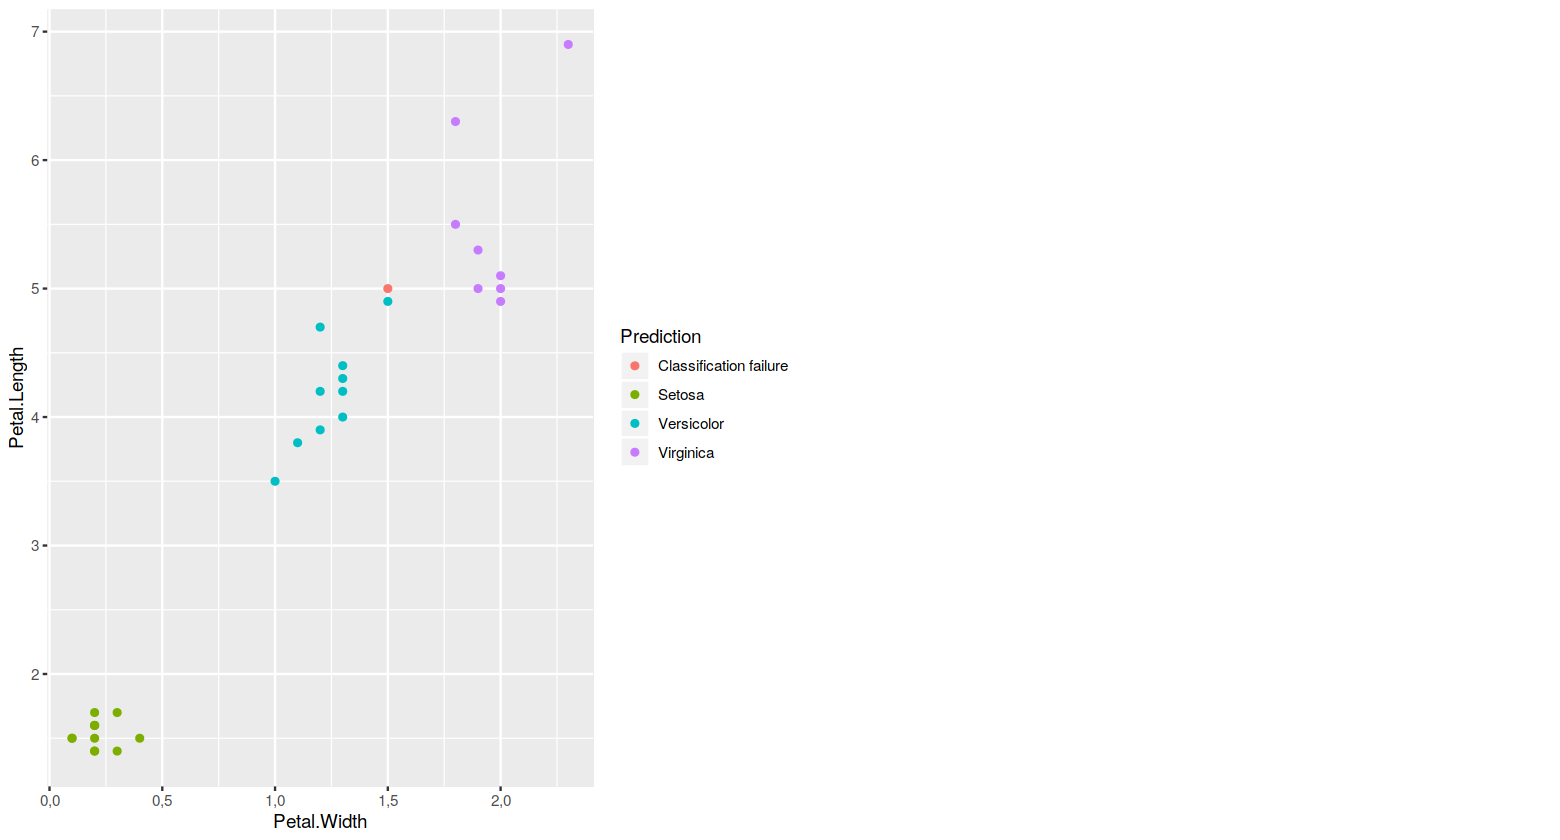

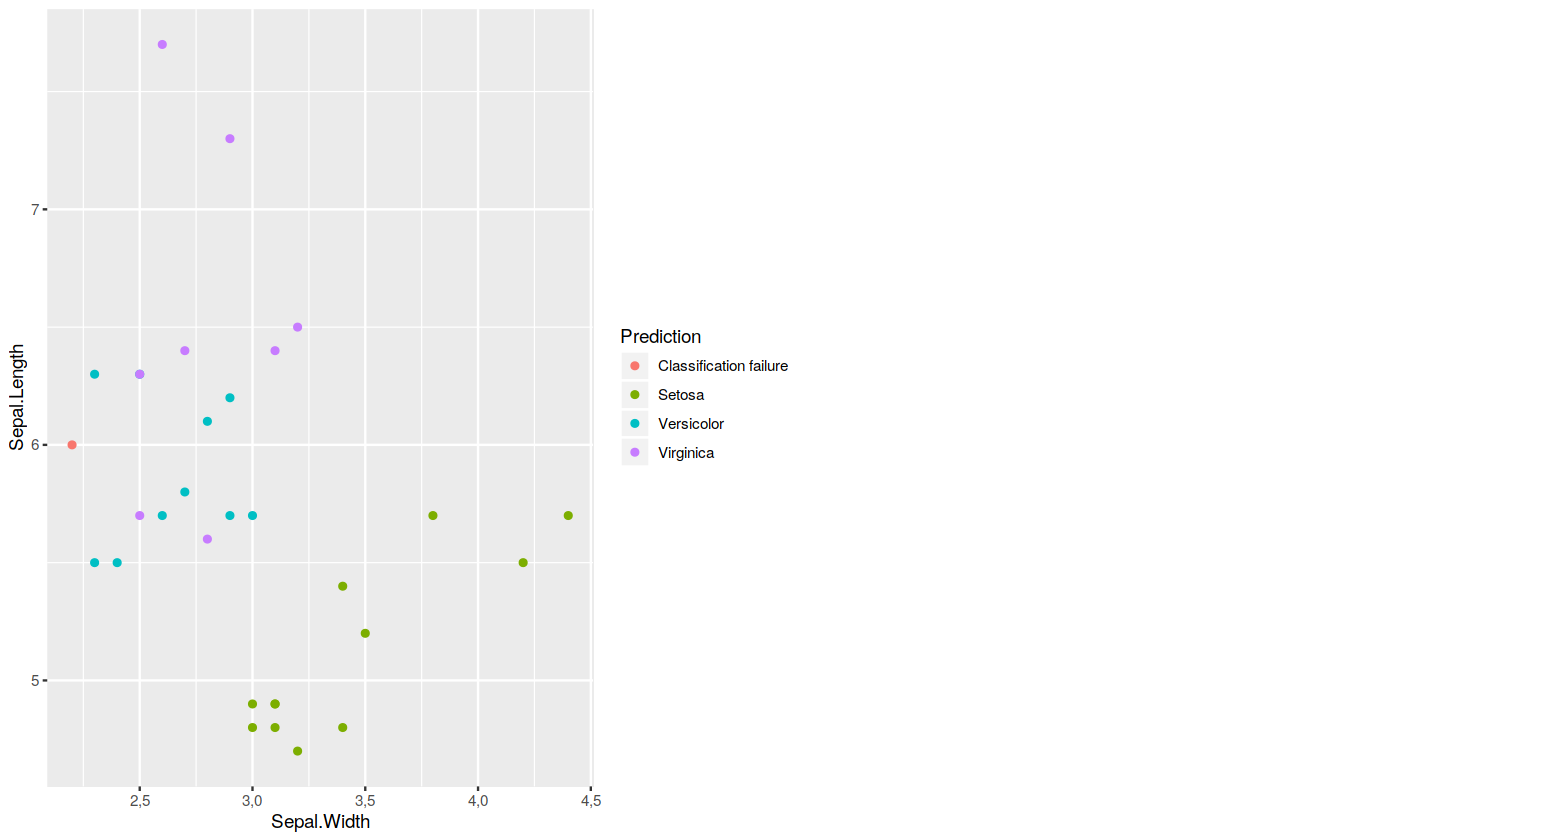

In [13]:
iris_fitted_forest <- random_forest_classifier(iris_split$train)
iris_predicted_forest <- prediction_evaluation(iris_split$test, iris_fitted_forest)
plot_predictions(iris_predicted_forest, x='Petal.Width', y='Petal.Length')
plot_predictions(iris_predicted_forest, x='Sepal.Width', y='Sepal.Length')